In [16]:
import keras
import keras.backend as K
import numpy as np
import pickle
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from preprocess_utils import preprocess, preprocess_input
import matplotlib.pyplot as plt
import argparse
from PIL import Image
%matplotlib inline

def load_preprocess(filename):
    with open(filename, mode='rb') as in_file:
        return pickle.load(in_file)


train_inputs, test_inputs, vocab_to_int, int_to_vocab = load_preprocess('preprocess.p')
transfer_values_train = load_preprocess('encoded_images_vgg16.p')
transfer_values_train = np.array(transfer_values_train)


state_size = 512
embedding_size = 128
transfer_values_size = transfer_values_train[0].shape[0]
num_words = len(int_to_vocab) + 1
batch_size = 1024


transfer_values_input = keras.layers.Input(shape=(transfer_values_size,), name='transfer_values_input')

decoder_transfer_map = keras.layers.Dense(state_size,
                                          activation='tanh',
                                          name='decoder_transfer_map')

decoder_input = keras.layers.Input(shape=(None, ), name='decoder_input')

decoder_embedding = keras.layers.embeddings.Embedding(input_dim=num_words,
                                                      output_dim=embedding_size,
                                                      name='decoder_embedding')

decoder_gru1 = keras.layers.GRU(state_size, name='decoder_gru1',
                                return_sequences=True)
decoder_gru2 = keras.layers.GRU(state_size, name='decoder_gru2',
                                return_sequences=True)
decoder_gru3 = keras.layers.GRU(state_size, name='decoder_gru3',
                                return_sequences=True)

decoder_dense = keras.layers.Dense(num_words,
                      activation='linear',
                      name='decoder_output')

def connect_decoder(transfer_values):
    
    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    
    net = keras.layers.Dropout(0.5)(net)
    net = decoder_gru3(net, initial_state=initial_state)
    
    net = keras.layers.Dropout(0.5)(net)
    decoder_output = decoder_dense(net)
    
    return decoder_output

decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = keras.models.Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])


def sparse_cross_entropy(y_true, y_pred):

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    loss_mean = tf.reduce_mean(loss)
    return loss_mean

optimizer = keras.optimizers.RMSprop(lr=1e-3)
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

try:
    decoder_model.load_weights('Model.h5')
except Exception:
    print("Model don't exist")





image_model = keras.applications.vgg16.VGG16(include_top=True, input_shape=(224,224,3))
transfer_layer = image_model.get_layer('fc2')
image_model_transfer = keras.models.Model(inputs=image_model.input,
                             outputs=transfer_layer.output)





def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """
    image = preprocess(image_path)
    
    transfer_value = image_model_transfer.predict(image)
    
    shape = (1, max_tokens)
    decoder_input_data_1 = np.zeros(shape=shape, dtype=np.int)
    token_int = vocab_to_int['<GO>']

    # Initialize an empty output-text.
    output_text = ''
    count_tokens = 0
    
    while token_int != vocab_to_int['<EOS>'] and count_tokens < max_tokens:
        
        decoder_input_data_1[0, count_tokens] = token_int


        x_data = {  'transfer_values_input': transfer_value,  'decoder_input': decoder_input_data_1}
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]

        token_int = np.argmax(token_onehot)

        sampled_word = int_to_vocab[token_int]
        
        if sampled_word != '<PAD>':
            output_text += " " + sampled_word

        count_tokens += 1
    
    pil_im = Image.open(image_path, 'r')
    plt.imshow(np.asarray(pil_im))
    
    print("Predicted caption:")
    print(output_text)
    
    print('\n\n Image:')
    print()





Predicted caption:
 child in red and black striped shirt is walking in front of a sports garden .


 Image:



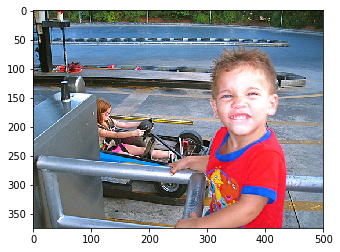

In [18]:
generate_caption('2.jpg')

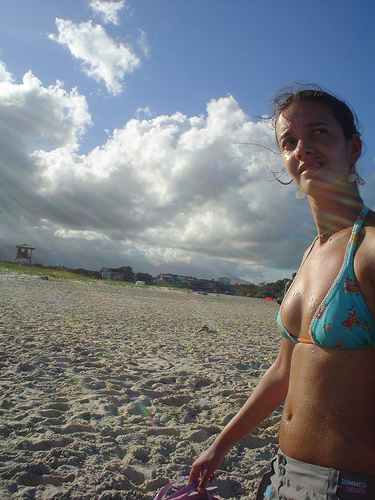

In [5]:
from IPython.display import Image 
Image(filename='1.jpg')